# FINAL PROJECT - SOCIAL MEDIA - AML3204

##  IMPORTING LIBRARIES

In [192]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import json
from tqdm.notebook import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score

In [ ]:
import warnings
warnings.filterwarnings("ignore")

## IMPORTING PROJECT DATA

In [ ]:
try:
  !git clone https://github.com/mlgomez0/social_media_analytics
  !mv social_media_analytics/recommender_systems/data/* .
  !rm -rf social_media_analytics
except:
  print("The files are already imported")

Cloning into 'social_media_analytics'...
remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 16 (delta 0), reused 13 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (16/16), 17.91 MiB | 14.04 MiB/s, done.


## 1. COLLABORATIVE FILTERING: MATRIX FACTORIZATION

### READING DATA

In [ ]:
# Reading data to get Ratings
head = ["user_id","item_id","rating","timestamp"]
df_rating = pd.read_csv("u.data",names=head,sep="\t")

In [ ]:
df_rating

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
...,...,...,...,...
99995,880,476,3,880175444
99996,716,204,5,879795543
99997,276,1090,1,874795795
99998,13,225,2,882399156


In [ ]:
df_rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   user_id    100000 non-null  int64
 1   item_id    100000 non-null  int64
 2   rating     100000 non-null  int64
 3   timestamp  100000 non-null  int64
dtypes: int64(4)
memory usage: 3.1 MB


In [ ]:
df_rating.user_id.nunique()

943

In [ ]:
df_rating.item_id.nunique()

1682

In [ ]:
df_rating.shape

(100000, 4)

In [ ]:
df_rating.isna().sum()

,0
user_id,0
item_id,0
rating,0
timestamp,0


In [ ]:
df_rating.duplicated().sum()

0

In [ ]:
df_pivoted = df_rating.pivot( index="user_id" , columns="item_id" , values="rating" )
df_pivoted

item_id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
940,NaN,NaN,NaN,2.0,NaN,NaN,4.0,5.0,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
941,5.0,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### ANALYSING THE SPARSE MATRIX

In [ ]:
# Getting the number of users and items from df_rating
n_users = len(df_rating.user_id.unique())
n_items = len(df_rating.item_id.unique())
print("Number of unique users:", n_users)
print("Number of unique movies:", n_items)
print("The full rating matrix will have:", n_users*n_items, 'elements.')
print('----------')
print("Number of ratings:", len(df_rating))
print("Therefore: ", len( df_rating ) / ( n_users * n_items ) * 100, '% of the matrix is filled.')
### Analizing the sparse matrix
print("We have an incredibly sparse matrix to work with here.")
print("And... as you can imagine, as the number of users and products grow, the number of elements will increase by n*2")
print("You are going to need a lot of memory to work with global scale... storing a full matrix in memory would be a challenge.")
print("One advantage here is that matrix factorization can realize the rating matrix implicitly, thus we don't need all the data")

Number of unique users: 943
Number of unique movies: 1682
The full rating matrix will have: 1586126 elements.
----------
Number of ratings: 100000
Therefore:  6.304669364224531 % of the matrix is filled.
We have an incredibly sparse matrix to work with here.
And... as you can imagine, as the number of users and products grow, the number of elements will increase by n*2
You are going to need a lot of memory to work with global scale... storing a full matrix in memory would be a challenge.
One advantage here is that matrix factorization can realize the rating matrix implicitly, thus we don't need all the data


### MATRIX FACTORIZATION MODEL

#### DATASET PREPARATION

In [90]:
data = df_rating.copy()

user_ids = data['user_id'].unique()
item_ids = data['item_id'].unique()

user_id_map = {id: idx for idx, id in enumerate(user_ids)}
item_id_map = {id: idx for idx, id in enumerate(item_ids)}


data['user_idx'] = data['user_id'].map(user_id_map)
data['item_idx'] = data['item_id'].map(item_id_map)

user_id_reverse_map = {idx: id for id, idx in user_id_map.items()}
item_id_reverse_map = {idx: id for id, idx in item_id_map.items()}

n_users = len(user_ids)
n_items = len(item_ids)

train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

class RatingsDataset(Dataset):
    def __init__(self, ratings):
        self.ratings = ratings

    def __len__(self):
        return len(self.ratings)

    def __getitem__(self, idx):
        user_id = self.ratings.iloc[idx, 4]
        item_id = self.ratings.iloc[idx, 5]
        rating = self.ratings.iloc[idx, 2]
        return user_id, item_id, rating

train_dataset = RatingsDataset(train_data)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [74]:
train_data.shape

(80000, 6)

In [75]:
test_data.shape

(20000, 6)

In [76]:
user_id_map[196]

0

In [78]:
user_id_reverse_map[0]

196

#### MODEL

In [79]:
class RecSysMF(torch.nn.Module):
    def __init__(self, n_users, n_items, n_factors=20):
        super(RecSysMF, self).__init__()
        self.user_factors = nn.Embedding(n_users, n_factors)
        self.item_factors = nn.Embedding(n_items, n_factors)

    def forward(self, user, item):
        user_embedding = self.user_factors(user)
        item_embedding = self.item_factors(item)
        return (user_embedding * item_embedding).sum(1)

#### MODEL EXPERIMENTS

In [160]:
def set_random_seed(seed: int):
    torch.manual_seed(seed)

    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    random.seed(seed)

    np.random.seed(seed)

In [161]:
set_random_seed(42)

In [162]:
def plot_training_epochs(epoch_results, label, range):
  plt.plot(epoch_results)
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title(f'Loss vs Epochs, {label}')

  plt.xticks(np.arange(1, range))

  plt.show()

In [81]:
def train_recommender_mf(model, train_dataloader, criterion, optimizer, n_epochs):
  epoch_results = []
  for epoch in tqdm(range(n_epochs)):
      model.train()
      total_loss = 0
      for user, item, rating in train_dataloader:
          user = user.long()
          item = item.long()
          rating = rating.float()

          optimizer.zero_grad()
          prediction = model(user, item)
          loss = criterion(prediction, rating)
          loss.backward()
          optimizer.step()

          total_loss += loss.item()
      epoch_loss = total_loss / len(train_dataloader)
      epoch_results.append(epoch_loss)
      print(f'Epoch {epoch+1}, Loss: {epoch_loss}')
  return epoch_results

In [100]:
def get_mse_rmse(model, test_users, test_items, test_ratings):
  model.eval()
  with torch.no_grad():
      test_predictions = model(test_users, test_items).numpy()

  mse = mean_squared_error(test_ratings, test_predictions)
  rmse = np.sqrt(mse)
  print(f'Test MSE: {mse}, Test RMSE: {rmse}')
  return mse, rmse

In [83]:
def recommend_movies(model, user_id, items_to_predict, user_id_map, item_id_map, item_id_reverse_map, top_n=10):

    user_idx = user_id_map[user_id]


    items_to_predict_idx = list([item_id_map[idx] for idx in items_to_predict])


    user_tensor = torch.tensor([user_idx] * len(items_to_predict_idx))

    item_tensor = torch.tensor(items_to_predict_idx)

    model.eval()
    with torch.no_grad():
        predictions = model(user_tensor, item_tensor)

    _, top_indices = torch.topk(predictions, top_n)

    recommended_item_ids = [item_id_reverse_map[items_to_predict_idx[idx]] for idx in top_indices]

    return recommended_item_ids

In [84]:
def get_top_rated_movies(user_id, data, top_n=10):
    user_data = data[data['user_id'] == user_id]
    top_rated_items = user_data.sort_values(by='rating', ascending=False).head(top_n)
    return top_rated_items['item_id'].values

In [85]:
def get_precision_at_k(test_data, model, user_id_map, item_id_map, item_id_reverse_map, top_n=10):
  test_users = test_data['user_id'].unique()
  precisions = []

  for user_id in test_users:
    items_to_predict = test_data[test_data['user_id'] == user_id]['item_id'].values
    if len(items_to_predict) >= 20:
      try:
        items_to_predict = random.sample(list(items_to_predict), 20)
        # Get top N recommended movies for the selected user
        recommended_movies = recommend_movies(model, user_id, items_to_predict, user_id_map, item_id_map, item_id_reverse_map, top_n)

        # Get top N rated movies for the selected user from the test set
        top_rated_movies = get_top_rated_movies(user_id, test_data, top_n)

        intersection = set(recommended_movies) & set(top_rated_movies)

        precision = len(intersection) / len(recommended_movies)

        precisions.append(precision)
      except:
        pass
  average_precision = np.mean(precisions)
  print(f"Average Precision: {average_precision}")
  return average_precision

In [112]:
def calculate_precision_recall_f1(model, test_data, user_id_map, item_id_map, item_id_reverse_map, k=10):
    precisions = []
    recalls = []
    f1_scores = []

    for user_id in test_data['user_id'].unique():
        actual_items = test_data[test_data['user_id'] == user_id]['item_id'].tolist()
        recommended_items = recommend_movies(model, user_id, item_id_map.keys(), user_id_map, item_id_map, item_id_reverse_map, top_n=k)

        actual_set = set(actual_items)
        recommended_set = set(recommended_items)

        true_positives = len(actual_set & recommended_set)
        precision = true_positives / len(recommended_set) if len(recommended_set) > 0 else 0
        recall = true_positives / len(actual_set) if len(actual_set) > 0 else 0

        precisions.append(precision)
        recalls.append(recall)
        if precision + recall > 0:
            f1_scores.append(2 * (precision * recall) / (precision + recall))
        else:
            f1_scores.append(0)

    avg_precision = sum(precisions) / len(precisions)
    avg_recall = sum(recalls) / len(recalls)
    avg_f1 = sum(f1_scores) / len(f1_scores)

    print(f'Precision@{k}: {avg_precision}')
    print(f'Recall@{k}: {avg_recall}')
    print(f'F1-Score@{k}: {avg_f1}')

    return avg_precision, avg_recall, avg_f1

In [114]:
def calculate_hit_rate(model, test_data, user_id_map, item_id_map, item_id_reverse_map, all_items, k=10):
    hit_count = 0
    total_users = len(test_data['user_id'].unique())

    for user_id in test_data['user_id'].unique():
        actual_items = test_data[test_data['user_id'] == user_id]['item_id'].tolist()
        recommended_items = recommend_movies(model, user_id, all_items, user_id_map, item_id_map, item_id_reverse_map, top_n=k)

        if len(set(actual_items) & set(recommended_items)) > 0:
            hit_count += 1

    hit_rate = hit_count / total_users
    print(f'Hit Rate@{k}: {hit_rate}')
    return hit_rate

In [271]:
def plot_metrics(experiments, mses, rmses, precisions_k, hit_rates_10, hit_rates_20):

  # Plot MSE
  plt.figure(figsize=(14, 8))

  plt.subplot(2, 3, 1)
  plt.plot(experiments, mses, marker='o', color='b')
  plt.title('MSE vs Experiments')
  plt.xlabel('Experiment')
  plt.ylabel('MSE')
  plt.grid(True)

  # Plot RMSE
  plt.subplot(2, 3, 2)
  plt.plot(experiments, rmses, marker='o', color='g')
  plt.title('RMSE vs Experiments')
  plt.xlabel('Experiment')
  plt.ylabel('RMSE')
  plt.grid(True)

  # Plot Precision@K
  plt.subplot(2, 3, 3)
  plt.plot(experiments, precisions_k, marker='o', color='r')
  plt.title('Mod Precision@10 vs Experiments')
  plt.xlabel('Experiment')
  plt.ylabel('Precision@K')
  plt.grid(True)

  # Plot Hit Rate@10
  plt.subplot(2, 3, 4)
  plt.plot(experiments, hit_rates_10, marker='o', color='c')
  plt.title('Hit Rate@10 vs Experiments')
  plt.xlabel('Experiment')
  plt.ylabel('Hit Rate@10')
  plt.grid(True)

  # Plot Hit Rate@20
  plt.subplot(2, 3, 5)
  plt.plot(experiments, hit_rates_20, marker='o', color='m')
  plt.title('Hit Rate@20 vs Experiments')
  plt.xlabel('Experiment')
  plt.ylabel('Hit Rate@20')
  plt.grid(True)

  # Adjust layout
  plt.tight_layout()

  # Show the plot
  plt.show()

In [163]:
test_users = torch.LongTensor(test_data['user_idx'].values)
test_items = torch.LongTensor(test_data['item_idx'].values)
test_ratings = test_data['rating'].values

In [164]:
# Test data items
test_items_unique = test_data['item_id'].unique()

In [165]:
mses_MF = []
rmses_MF = []
precisions_k_MF = []
hit_rates_10_MF = []
hit_rates_20_MF = []

##### Experiment 1: 20 latent factors

In [166]:
model = RecSysMF(n_users, n_items)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
n_epochs = 10

In [167]:
epoch_results_e1 = train_recommender_mf(model, train_dataloader, criterion, optimizer, n_epochs)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1, Loss: 21.686359950256346
Epoch 2, Loss: 3.72020807094574
Epoch 3, Loss: 1.2709763642311096
Epoch 4, Loss: 0.9739845892429352
Epoch 5, Loss: 0.9114865731477737
Epoch 6, Loss: 0.9013243655204773
Epoch 7, Loss: 0.8693093554735184
Epoch 8, Loss: 0.8153313149929047
Epoch 9, Loss: 0.7847305615186692
Epoch 10, Loss: 0.7518199701070786


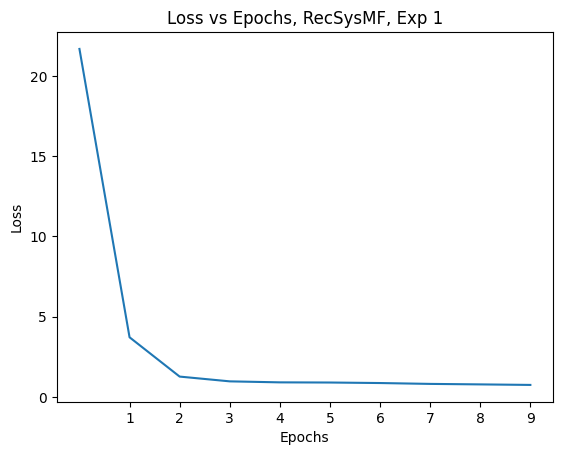

In [168]:
plot_training_epochs(epoch_results_e1, "RecSysMF, Exp 1", 10)

In [169]:
precision_10, recall_10, f1_10 = calculate_precision_recall_f1(model, test_data, user_id_map, item_id_map, item_id_reverse_map, k=10)

Precision@10: 0.0013829787234042555
Recall@10: 0.0006112771030609025
F1-Score@10: 0.000706680166256877


In [170]:
precision_20, recall_20, f1_20 = calculate_precision_recall_f1(model, test_data, user_id_map, item_id_map, item_id_reverse_map, k=20)

Precision@20: 0.0030851063829787214
Recall@20: 0.0023207102383009277
F1-Score@20: 0.0021583711796484763


Note: The metrics above are too small; this is because the items the users have not seen are too big compared to the items the users have interacted with. Therefore, it is unlikely that the recommender shows at the top exactly the movies the user has seen.

In [171]:
mse, rmse = get_mse_rmse(model, test_users, test_items, test_ratings)
precision_k = get_precision_at_k(test_data, model, user_id_map, item_id_map, item_id_reverse_map, top_n=10)
hit_rate_10 = calculate_hit_rate(model, test_data, user_id_map, item_id_map, item_id_reverse_map, test_items_unique, k=10)
hit_rate_20 = calculate_hit_rate(model, test_data, user_id_map, item_id_map, item_id_reverse_map, test_items_unique, k=20)
mses_MF.append(mse)
rmses_MF.append(rmse)
precisions_k_MF.append(precision_k)
hit_rates_10_MF.append(hit_rate_10)
hit_rates_20_MF.append(hit_rate_20)

Test MSE: 1.4502619001721506, Test RMSE: 1.2042682010964794
Average Precision: 0.38309859154929576
Hit Rate@10: 0.03829787234042553
Hit Rate@20: 0.10319148936170212


##### Experiment 2: 10 latent factors

In [172]:
model = RecSysMF(n_users, n_items, n_factors=10)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
n_epochs = 10

In [173]:
epoch_results_e2 = train_recommender_mf(model, train_dataloader, criterion, optimizer, n_epochs)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1, Loss: 17.235151478195192
Epoch 2, Loss: 3.3119573721408844
Epoch 3, Loss: 1.144494113779068
Epoch 4, Loss: 0.9574950119018555
Epoch 5, Loss: 0.9093217979907989
Epoch 6, Loss: 0.8732918693780899
Epoch 7, Loss: 0.8467685165643692
Epoch 8, Loss: 0.8150921334266663
Epoch 9, Loss: 0.7920773412704468
Epoch 10, Loss: 0.7755710373401642


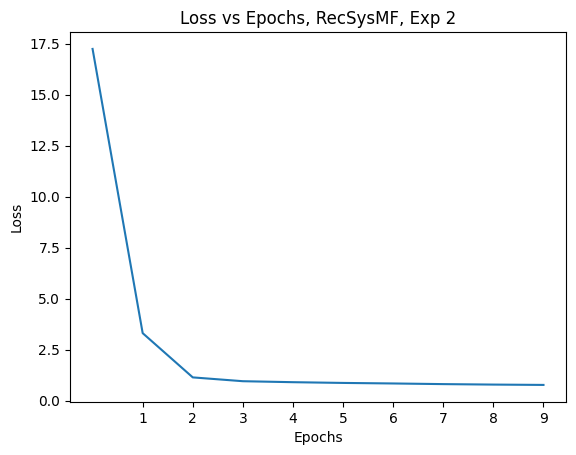

In [174]:
plot_training_epochs(epoch_results_e2, "RecSysMF, Exp 2", 10)

In [175]:
mse, rmse = get_mse_rmse(model, test_users, test_items, test_ratings)
precision_k = get_precision_at_k(test_data, model, user_id_map, item_id_map, item_id_reverse_map, top_n=10)
hit_rate_10 = calculate_hit_rate(model, test_data, user_id_map, item_id_map, item_id_reverse_map, test_items_unique, k=10)
hit_rate_20 = calculate_hit_rate(model, test_data, user_id_map, item_id_map, item_id_reverse_map, test_items_unique, k=20)
mses_MF.append(mse)
rmses_MF.append(rmse)
precisions_k_MF.append(precision_k)
hit_rates_10_MF.append(hit_rate_10)
hit_rates_20_MF.append(hit_rate_20)

Test MSE: 1.1718527387808022, Test RMSE: 1.0825214726650008
Average Precision: 0.3949295774647887
Hit Rate@10: 0.027659574468085105
Hit Rate@20: 0.10957446808510639


##### Experiment 3: 5 latent factors

In [176]:
model = RecSysMF(n_users, n_items, n_factors=5)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
n_epochs = 10

In [177]:
epoch_results_e3 = train_recommender_mf(model, train_dataloader, criterion, optimizer, n_epochs)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1, Loss: 14.607179263687133
Epoch 2, Loss: 2.7725216857910158
Epoch 3, Loss: 1.074245204591751
Epoch 4, Loss: 0.9398013628959656
Epoch 5, Loss: 0.8994535048484802
Epoch 6, Loss: 0.8704133165836334
Epoch 7, Loss: 0.851491740655899
Epoch 8, Loss: 0.8373980357885361
Epoch 9, Loss: 0.8283193141222001
Epoch 10, Loss: 0.8180952972412109


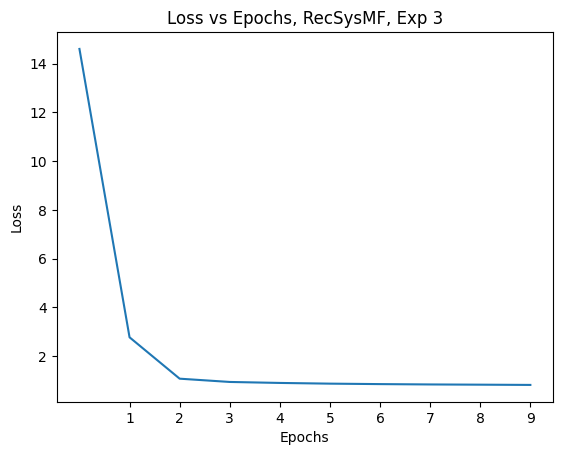

In [178]:
plot_training_epochs(epoch_results_e3, "RecSysMF, Exp 3", 10)

In [179]:
mse, rmse = get_mse_rmse(model, test_users, test_items, test_ratings)
precision_k = get_precision_at_k(test_data, model, user_id_map, item_id_map, item_id_reverse_map, top_n=10)
hit_rate_10 = calculate_hit_rate(model, test_data, user_id_map, item_id_map, item_id_reverse_map, test_items_unique, k=10)
hit_rate_20 = calculate_hit_rate(model, test_data, user_id_map, item_id_map, item_id_reverse_map, test_items_unique, k=20)
mses_MF.append(mse)
rmses_MF.append(rmse)
precisions_k_MF.append(precision_k)
hit_rates_10_MF.append(hit_rate_10)
hit_rates_20_MF.append(hit_rate_20)

Test MSE: 1.0195477709521907, Test RMSE: 1.009726582274722
Average Precision: 0.39464788732394374
Hit Rate@10: 0.04893617021276596
Hit Rate@20: 0.16489361702127658


##### Results

In [185]:
experiments = ["20", "10", "5"]

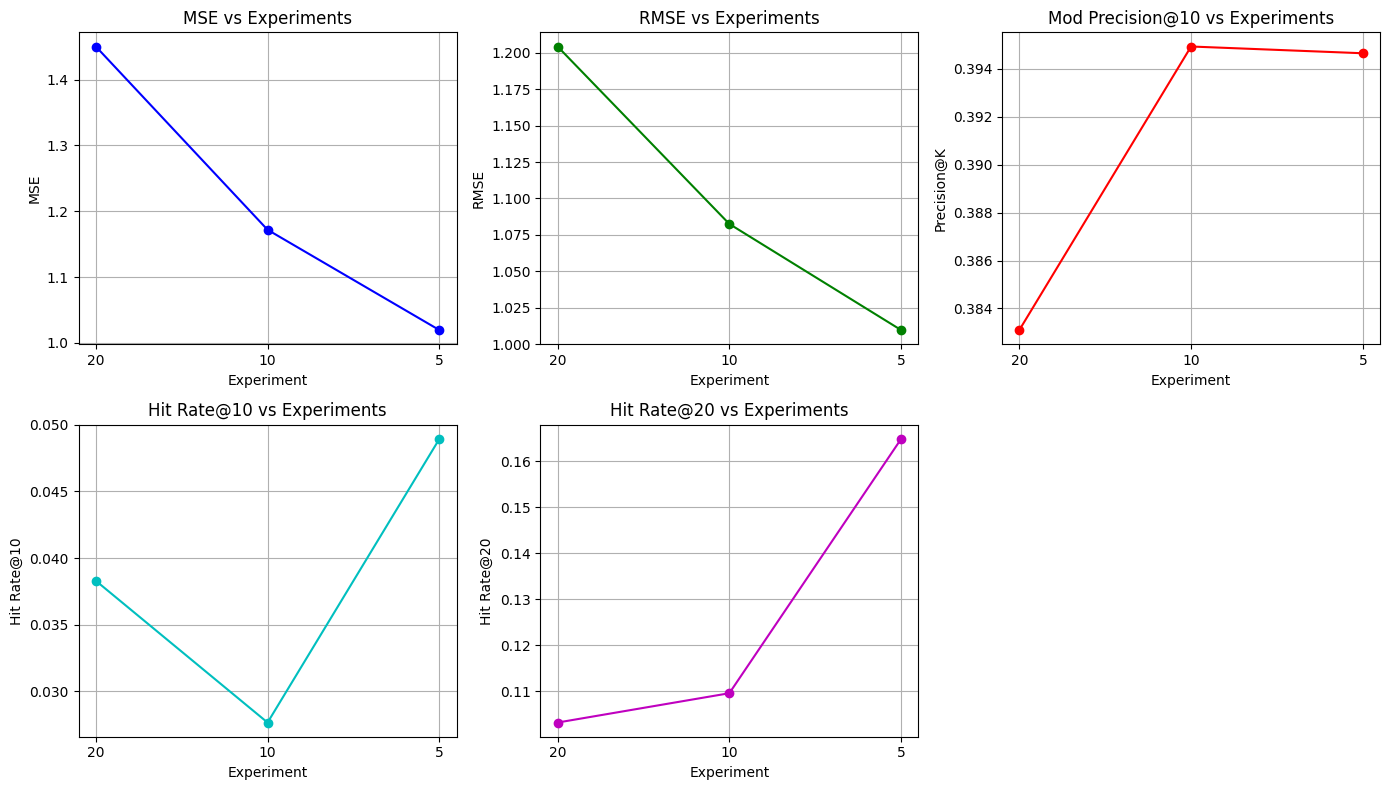

In [194]:
plot_metrics(experiments, mses_MF, rmses_MF, precisions_k_MF, hit_rates_10_MF, hit_rates_20_MF)

## 2. HYBRID RECOMMENDER SYSTEM

### DATASET PREPARATION


#### Sentiment Analysis

In [187]:
df = pd.read_csv("sentiment_analysis_final2.csv")

In [188]:
df['comments'] = df.loc[:, '0':'19'].values.tolist()

In [189]:
df.shape

(1677, 24)

In [190]:
do_sentiment_analysis = False

In [191]:
# function to get the sentiment analysis for the comments in each movie using Hugging Face transformers

def get_sentiment(comments):
  sentiment_classifier = pipeline(
        model="lxyuan/distilbert-base-multilingual-cased-sentiments-student"
    )
  result = []
  for comments_list in comments:
    scores = []
    for comment in comments_list:
      if len(scores) > 100:
        break
      try:
        sentiment = sentiment_classifier(comment, truncation=True)
        sentiment = sentiment[0]
        scores.append({sentiment['label']: sentiment['score']})
      except Exception as e:
        print(f"There was an error getting sentiment {e}")
    result.append(scores)
  return result

In [195]:
# Process the columns in batches
def process_sentiments(batch_size, path, data):
  result = []
  for start in range(0, len(data), batch_size):
    end = start + batch_size
    batch = data.iloc[start:end]
    result += get_sentiment(batch['comments'])
    with open(path, 'w') as file:
      json.dump(result, file)
  return result

In [196]:
# do sentiment analysis or import file with analysis made before
if do_sentiment_analysis:
  process_sentiments(100, 'sentiments.json', df)

In [197]:
def get_sentiment_scores(sentiments):
  positive = []
  negative = []
  for sentiment in sentiments:
    positive_count = 0
    negative_count = 0
    positive_sum = 0
    negative_sum = 0
    for item in sentiment:
      if item and 'negative' in item.keys():
        negative_count += 1
        negative_sum += item['negative']
      elif item and 'positive' in item.keys():
        positive_count += 1
        positive_sum += item['positive']
      else:
        continue
    if not positive_count:
      positive.append(None)
    else:
      positive.append(positive_sum / positive_count)
    if not negative_count:
      negative.append(None)
    else:
      negative.append(negative_sum / negative_count)
  return positive, negative

In [198]:
sentiments = pd.read_json('sentiments.json').values

In [199]:
len(sentiments)

1677

In [200]:
positive, _ = get_sentiment_scores(sentiments)

#### Final Dataset

In [201]:
df_items = pd.read_csv('u.item', sep='|', header=None, encoding='latin-1')

In [202]:
df_items.head()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [203]:
df_items.shape

(1682, 24)

In [204]:
data = df_items.iloc[:1677, :]

In [205]:
data['item_id'] = df_items.iloc[:1677, 0]
data['positive'] = positive

In [206]:
data.head()

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,item_id,positive
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,1,0.724138
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,1,0,0,2,0.725342
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,1,0,0,3,0.585432
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,4,0.668227
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,1,0,0,5,0.670225


In [207]:
data.drop(columns=[0,1, 2,3,4], inplace=True)

In [208]:
data.head()

,5,6,7,8,9,10,11,12,13,14,...,16,17,18,19,20,21,22,23,item_id,positive
0,0,0,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0.724138
1,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,2,0.725342
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,3,0.585432
3,0,1,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,4,0.668227
4,0,0,0,0,0,0,1,0,1,0,...,0,0,0,0,0,1,0,0,5,0.670225


In [209]:
data.shape

(1677, 21)

In [210]:
df_genre = pd.read_csv('u.genre', sep='|', header=None, encoding='latin-1')

In [211]:
def add_five(x):
  return x + 5

In [212]:
df_genre.iloc[:, 1] = df_genre.iloc[:, 1].apply(add_five)

In [213]:
df_genre

,0,1
0,unknown,5
1,Action,6
2,Adventure,7
3,Animation,8
4,Children's,9
5,Comedy,10
6,Crime,11
7,Documentary,12
8,Drama,13
9,Fantasy,14


In [214]:
data.isna().sum()

,0
5,0
6,0
7,0
8,0
9,0
10,0
11,0
12,0
13,0
14,0


In [215]:
data.dropna(inplace=True)

In [216]:
data.isna().sum()

,0
5,0
6,0
7,0
8,0
9,0
10,0
11,0
12,0
13,0
14,0


In [217]:
head = ["user_id","item_id","rating","timestamp"]
df_user_rating = pd.read_csv("u.data",names=head,sep="\t")

In [218]:
df_user_rating.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


#### Merge the datasets

In [219]:
dataset = pd.merge(data, df_user_rating, on='item_id')

In [220]:
dataset.head()

,5,6,7,8,9,10,11,12,13,14,...,19,20,21,22,23,item_id,positive,user_id,rating,timestamp
0,0,0,0,1,1,1,0,0,0,0,...,0,0,0,0,0,1,0.724138,308,4,887736532
1,0,0,0,1,1,1,0,0,0,0,...,0,0,0,0,0,1,0.724138,287,5,875334088
2,0,0,0,1,1,1,0,0,0,0,...,0,0,0,0,0,1,0.724138,148,4,877019411
3,0,0,0,1,1,1,0,0,0,0,...,0,0,0,0,0,1,0.724138,280,4,891700426
4,0,0,0,1,1,1,0,0,0,0,...,0,0,0,0,0,1,0.724138,66,3,883601324


In [221]:
dataset.shape

(99397, 24)

In [222]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99397 entries, 0 to 99396
Data columns (total 24 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   5          99397 non-null  int64  
 1   6          99397 non-null  int64  
 2   7          99397 non-null  int64  
 3   8          99397 non-null  int64  
 4   9          99397 non-null  int64  
 5   10         99397 non-null  int64  
 6   11         99397 non-null  int64  
 7   12         99397 non-null  int64  
 8   13         99397 non-null  int64  
 9   14         99397 non-null  int64  
 10  15         99397 non-null  int64  
 11  16         99397 non-null  int64  
 12  17         99397 non-null  int64  
 13  18         99397 non-null  int64  
 14  19         99397 non-null  int64  
 15  20         99397 non-null  int64  
 16  21         99397 non-null  int64  
 17  22         99397 non-null  int64  
 18  23         99397 non-null  int64  
 19  item_id    99397 non-null  int64  
 20  positi

#### Prepare dataset

In [223]:
# Encode user_id and item_id to numerical indices for the model
user_id_map = {id: idx for idx, id in enumerate(dataset['user_id'].unique())}
item_id_map = {id: idx for idx, id in enumerate(dataset['item_id'].unique())}
user_id_reverse_map = {idx: id for id, idx in user_id_map.items()}
item_id_reverse_map = {idx: id for id, idx in item_id_map.items()}
dataset['user_idx'] = dataset['user_id'].map(user_id_map)
dataset['item_idx'] = dataset['item_id'].map(item_id_map)


In [224]:
dataset.head()

,5,6,7,8,9,10,11,12,13,14,...,21,22,23,item_id,positive,user_id,rating,timestamp,user_idx,item_idx
0,0,0,0,1,1,1,0,0,0,0,...,0,0,0,1,0.724138,308,4,887736532,0,0
1,0,0,0,1,1,1,0,0,0,0,...,0,0,0,1,0.724138,287,5,875334088,1,0
2,0,0,0,1,1,1,0,0,0,0,...,0,0,0,1,0.724138,148,4,877019411,2,0
3,0,0,0,1,1,1,0,0,0,0,...,0,0,0,1,0.724138,280,4,891700426,3,0
4,0,0,0,1,1,1,0,0,0,0,...,0,0,0,1,0.724138,66,3,883601324,4,0


In [225]:
train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)

In [226]:
genre_columns = [i for i in range(5, 24)]

In [227]:
class RecommenderDataset(Dataset):
    def __init__(self, data, genre_columns):
        self.user_idx = torch.tensor(data['user_idx'].values, dtype=torch.long)
        self.item_idx = torch.tensor(data['item_idx'].values, dtype=torch.long)
        self.ratings = torch.tensor(data['rating'].values, dtype=torch.float32)
        self.genres = torch.tensor(data[genre_columns].values, dtype=torch.float32)
        self.sentiment = torch.tensor(data['positive'].values, dtype=torch.float32)

    def __len__(self):
        return len(self.user_idx)

    def __getitem__(self, idx):
        return (self.user_idx[idx], self.item_idx[idx], self.ratings[idx], self.genres[idx], self.sentiment[idx])

train_dataset = RecommenderDataset(train_data, genre_columns)
test_dataset = RecommenderDataset(test_data, genre_columns)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

### MODEL

In [228]:
class HybridRecSys(nn.Module):
    def __init__(self, num_users, num_items, num_genres, embedding_dim):
        super(HybridRecSys, self).__init__()
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.item_embedding = nn.Embedding(num_items, embedding_dim)
        self.genre_embedding = nn.Linear(num_genres, embedding_dim)
        self.sentiment_fc = nn.Linear(1, embedding_dim)

        self.fc1 = nn.Linear(embedding_dim * 4, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

        self.relu = nn.ReLU()

    def forward(self, user, item, genres, sentiment):
        user_embedded = self.user_embedding(user)
        item_embedded = self.item_embedding(item)
        genre_embedded = self.relu(self.genre_embedding(genres))
        sentiment_embedded = self.relu(self.sentiment_fc(sentiment.unsqueeze(1)))

        x = torch.cat([user_embedded, item_embedded, genre_embedded, sentiment_embedded], dim=-1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)

        return x.squeeze()

In [229]:
def train_hybrid_recommender(model, dataloader, criterion, optimizer, num_epochs):
  losses = []
  for epoch in range(num_epochs):
      model.train()
      running_loss = 0.0
      for user, item, rating, genres, sentiment in dataloader:
          optimizer.zero_grad()

          outputs = model(user, item, genres, sentiment)
          loss = criterion(outputs, rating)
          loss.backward()
          optimizer.step()
          running_loss += loss.item()
      avg_loss = running_loss / len(dataloader)
      losses.append(avg_loss)
      print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss}')
  return losses

### EXPERIMENTS

In [237]:
def get_mse_rmse_hybrid(model, test_ratings, test_users, test_items, test_genres, test_sentiments):
  model.eval()
  with torch.no_grad():
      test_predictions = model(test_users, test_items, test_genres, test_sentiments).numpy()

  mse = mean_squared_error(test_ratings, test_predictions)
  rmse = np.sqrt(mse)
  print(f'Test MSE: {mse}, Test RMSE: {rmse}')
  return mse, rmse

In [231]:
def recommend_movies_hybrid(model, user_id, items_to_predict, genre_data, sentiment_data, user_id_map, item_id_map, item_id_reverse_map, top_n=10):

    user_idx = user_id_map[user_id]


    items_to_predict_idx = list([item_id_map[idx] for idx in items_to_predict])


    user_tensor = torch.tensor([user_idx] * len(items_to_predict_idx))

    item_tensor = torch.tensor(items_to_predict_idx)

    # Extract genres and sentiments for the items to predict
    genre_tensor = torch.FloatTensor(genre_data)
    sentiment_tensor = torch.FloatTensor(sentiment_data)

    model.eval()
    with torch.no_grad():
        predictions = model(user_tensor, item_tensor, genre_tensor, sentiment_tensor)

    _, top_indices = torch.topk(predictions, top_n)

    recommended_item_ids = [item_id_reverse_map[items_to_predict_idx[idx]] for idx in top_indices]

    return recommended_item_ids

In [235]:
def calculate_hit_rate_hybrid(model, test_data, user_id_map, item_id_map, item_id_reverse_map, all_items, k=10):
    hit_count = 0
    total_users = len(test_data['user_id'].unique())

    for user_id in test_data['user_id'].unique():
        actual_items = test_data[test_data['user_id'] == user_id]['item_id'].tolist()
        items_to_predict = sorted(list(all_items))
        relevant_cols = ['item_id'] + genre_columns + ['positive']
        filtered_data = test_data[test_data['item_id'].isin(items_to_predict)]
        sorted_filtered = filtered_data.sort_values(by='item_id')
        final_data = sorted_filtered[relevant_cols].drop_duplicates()
        genre_data = final_data[genre_columns].values
        sentiment_data = final_data['positive'].values
        recommended_items = recommend_movies_hybrid(model, user_id, all_items, genre_data, sentiment_data, user_id_map, item_id_map, item_id_reverse_map, top_n=k)

        if len(set(actual_items) & set(recommended_items)) > 0:
            hit_count += 1

    hit_rate = hit_count / total_users
    print(f'Hit Rate@{k}: {hit_rate}')
    return hit_rate

In [232]:
def get_precision_at_k_hybrid(test_data, model, user_id_map, item_id_map, item_id_reverse_map, top_n=10):
  test_users = test_data['user_id'].unique()
  precisions = []

  for user_id in test_users:
    items_to_predict = test_data[test_data['user_id'] == user_id]['item_id'].values
    if len(items_to_predict) >= 20:
      try:
        items_to_predict = sorted(random.sample(list(items_to_predict), 20))
        relevant_cols = ['item_id'] + genre_columns + ['positive']
        filtered_data = test_data[test_data['item_id'].isin(items_to_predict)]
        sorted_filtered = filtered_data.sort_values(by='item_id')
        final_data = sorted_filtered[relevant_cols].drop_duplicates()
        genre_data = final_data[genre_columns].values
        sentiment_data = final_data['positive'].values
        # Get top N recommended movies for the selected user
        recommended_movies = recommend_movies_hybrid(model, user_id, items_to_predict, genre_data, sentiment_data, user_id_map, item_id_map, item_id_reverse_map, top_n)
        # Get top N rated movies for the selected user from the test set
        top_rated_movies = get_top_rated_movies(user_id, test_data, top_n)

        intersection = set(recommended_movies) & set(top_rated_movies)

        precision = len(intersection) / len(recommended_movies)

        precisions.append(precision)
      except:
        pass
  average_precision = np.mean(precisions)
  print(f"Average Precision: {average_precision}")
  return average_precision

In [233]:
test_users = torch.LongTensor(test_data['user_idx'].values)
test_items = torch.LongTensor(test_data['item_idx'].values)
test_ratings = test_data['rating'].values
test_genres = torch.FloatTensor(test_data[genre_columns].values)
test_sentiments = torch.FloatTensor(test_data['positive'].values)

In [234]:
num_users = len(user_id_map)
num_items = len(item_id_map)
num_genres = len(genre_columns)

In [256]:
mses_HD = []
rmses_HD = []
precisions_k_HD = []
hit_rates_10_HD = []
hit_rates_20_HD = []

In [243]:
test_items_unique = test_data['item_id'].unique()

##### Exp 1: 50 embedding dim, 10 epochs

In [250]:
embedding_dim = 50
num_epochs = 10

model = HybridRecSys(num_users, num_items, num_genres, embedding_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

losses_e1 = train_hybrid_recommender(model, train_dataloader, criterion, optimizer, num_epochs)

Epoch 1/10, Loss: 1.2536759030790168
Epoch 2/10, Loss: 0.9521194603878552
Epoch 3/10, Loss: 0.8926468755291627
Epoch 4/10, Loss: 0.8601987428321823
Epoch 5/10, Loss: 0.8340692536924889
Epoch 6/10, Loss: 0.814909252517183
Epoch 7/10, Loss: 0.79214799696653
Epoch 8/10, Loss: 0.7732660794152623
Epoch 9/10, Loss: 0.7512025619742377
Epoch 10/10, Loss: 0.7291601544076746


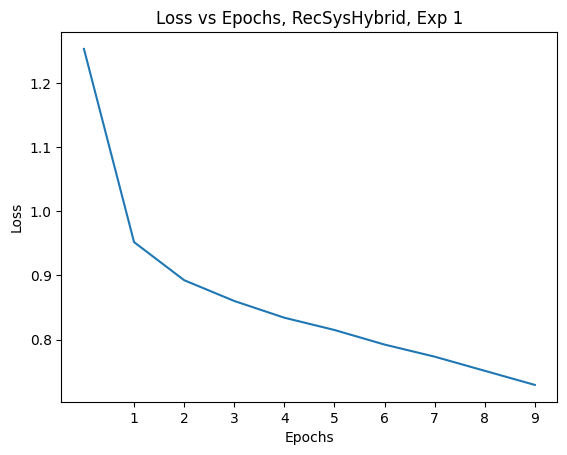

In [253]:
plot_training_epochs(losses_e1, "RecSysHybrid, Exp 1", 10)

In [257]:
mse, rmse = get_mse_rmse_hybrid(model, test_ratings, test_users, test_items, test_genres, test_sentiments)
precision_k = get_precision_at_k_hybrid(test_data, model, user_id_map, item_id_map, item_id_reverse_map, top_n=10)
hit_rate_10 = calculate_hit_rate_hybrid(model, test_data, user_id_map, item_id_map, item_id_reverse_map, test_items_unique, k=10)
hit_rate_20 = calculate_hit_rate_hybrid(model, test_data, user_id_map, item_id_map, item_id_reverse_map, test_items_unique, k=20)
mses_HD.append(mse)
rmses_HD.append(rmse)
precisions_k_HD.append(precision_k)
hit_rates_10_HD.append(hit_rate_10)
hit_rates_20_HD.append(hit_rate_20)

Test MSE: 0.941354684098898, Test RMSE: 0.970234344938839
Average Precision: 0.383008356545961
Hit Rate@10: 0.1902231668437832
Hit Rate@20: 0.3145589798087141


##### Exp 2: 50 embedding dim, 15 epochs

In [259]:
embedding_dim = 50
num_epochs = 15

model = HybridRecSys(num_users, num_items, num_genres, embedding_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

losses_e2 = train_hybrid_recommender(model, train_dataloader, criterion, optimizer, num_epochs)

Epoch 1/15, Loss: 1.2655354448124372
Epoch 2/15, Loss: 0.9572876130057647
Epoch 3/15, Loss: 0.8973167732130206
Epoch 4/15, Loss: 0.8606900770100296
Epoch 5/15, Loss: 0.8345847971383737
Epoch 6/15, Loss: 0.8098461644024209
Epoch 7/15, Loss: 0.7904298832506684
Epoch 8/15, Loss: 0.7659574956876658
Epoch 9/15, Loss: 0.744278166553999
Epoch 10/15, Loss: 0.7201096991186456
Epoch 11/15, Loss: 0.6957041784485597
Epoch 12/15, Loss: 0.6701840494106781
Epoch 13/15, Loss: 0.6394949695897122
Epoch 14/15, Loss: 0.6108770409564481
Epoch 15/15, Loss: 0.5812086884474812


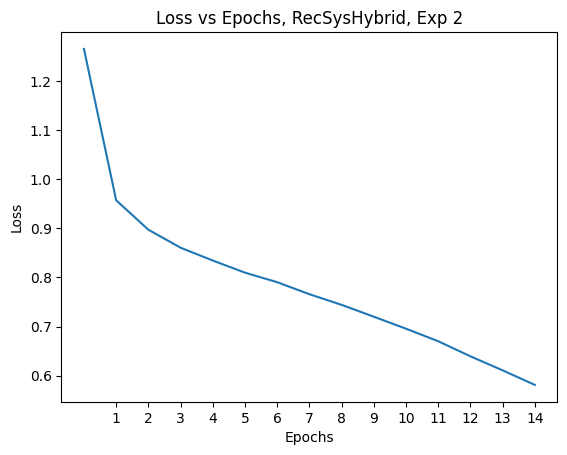

In [261]:
plot_training_epochs(losses_e2, "RecSysHybrid, Exp 2", 15)

In [262]:
mse, rmse = get_mse_rmse_hybrid(model, test_ratings, test_users, test_items, test_genres, test_sentiments)
precision_k = get_precision_at_k_hybrid(test_data, model, user_id_map, item_id_map, item_id_reverse_map, top_n=10)
hit_rate_10 = calculate_hit_rate_hybrid(model, test_data, user_id_map, item_id_map, item_id_reverse_map, test_items_unique, k=10)
hit_rate_20 = calculate_hit_rate_hybrid(model, test_data, user_id_map, item_id_map, item_id_reverse_map, test_items_unique, k=20)
mses_HD.append(mse)
rmses_HD.append(rmse)
precisions_k_HD.append(precision_k)
hit_rates_10_HD.append(hit_rate_10)
hit_rates_20_HD.append(hit_rate_20)

Test MSE: 1.0267652529711433, Test RMSE: 1.0132942578398159
Average Precision: 0.3807799442896936
Hit Rate@10: 0.1636556854410202
Hit Rate@20: 0.29861849096705634


##### Exp 3: 50 embedding dim, 20 epochs



In [263]:
embedding_dim = 50
num_epochs = 20

model = HybridRecSys(num_users, num_items, num_genres, embedding_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

losses_e3 = train_hybrid_recommender(model, train_dataloader, criterion, optimizer, num_epochs)

Epoch 1/20, Loss: 1.256381761951017
Epoch 2/20, Loss: 0.9489012266586409
Epoch 3/20, Loss: 0.8920147249224871
Epoch 4/20, Loss: 0.8586218844281025
Epoch 5/20, Loss: 0.8358865130216195
Epoch 6/20, Loss: 0.813860008051006
Epoch 7/20, Loss: 0.7927010559258879
Epoch 8/20, Loss: 0.7711345382927889
Epoch 9/20, Loss: 0.748959394850658
Epoch 10/20, Loss: 0.7255242814820136
Epoch 11/20, Loss: 0.6992827717181855
Epoch 12/20, Loss: 0.671568047899636
Epoch 13/20, Loss: 0.6421511637665817
Epoch 14/20, Loss: 0.61003139750524
Epoch 15/20, Loss: 0.581143352813713
Epoch 16/20, Loss: 0.5496787036126981
Epoch 17/20, Loss: 0.5223645460720707
Epoch 18/20, Loss: 0.4954752904195893
Epoch 19/20, Loss: 0.46984964755400477
Epoch 20/20, Loss: 0.4484766378866888


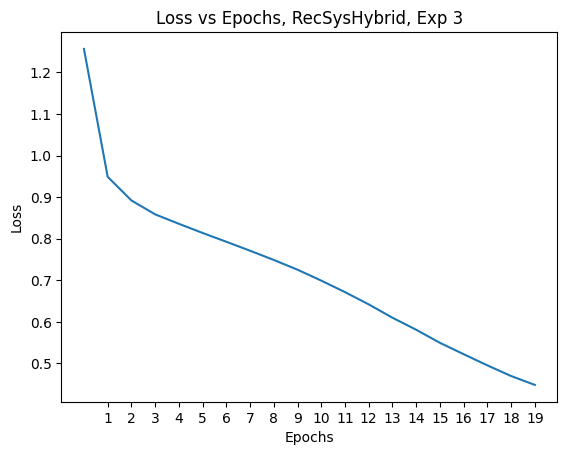

In [264]:
plot_training_epochs(losses_e3, "RecSysHybrid, Exp 3", 20)

In [265]:
mse, rmse = get_mse_rmse_hybrid(model, test_ratings, test_users, test_items, test_genres, test_sentiments)
precision_k = get_precision_at_k_hybrid(test_data, model, user_id_map, item_id_map, item_id_reverse_map, top_n=10)
hit_rate_10 = calculate_hit_rate_hybrid(model, test_data, user_id_map, item_id_map, item_id_reverse_map, test_items_unique, k=10)
hit_rate_20 = calculate_hit_rate_hybrid(model, test_data, user_id_map, item_id_map, item_id_reverse_map, test_items_unique, k=20)
mses_HD.append(mse)
rmses_HD.append(rmse)
precisions_k_HD.append(precision_k)
hit_rates_10_HD.append(hit_rate_10)
hit_rates_20_HD.append(hit_rate_20)

Test MSE: 1.148826244676213, Test RMSE: 1.071833123520734
Average Precision: 0.364066852367688
Hit Rate@10: 0.15196599362380447
Hit Rate@20: 0.28374070138150903


In [267]:
mses_HD

[0.941354684098898, 1.0267652529711433, 1.148826244676213]

In [269]:
mses_HD, rmses_HD, precisions_k_HD, hit_rates_10_HD, hit_rates_20_HD

([0.941354684098898, 1.0267652529711433, 1.148826244676213],
 [0.970234344938839, 1.0132942578398159, 1.071833123520734],
 [0.383008356545961, 0.3807799442896936, 0.364066852367688],
 [0.1902231668437832, 0.1636556854410202, 0.15196599362380447],
 [0.3145589798087141, 0.29861849096705634, 0.28374070138150903])

##### Epochs Results

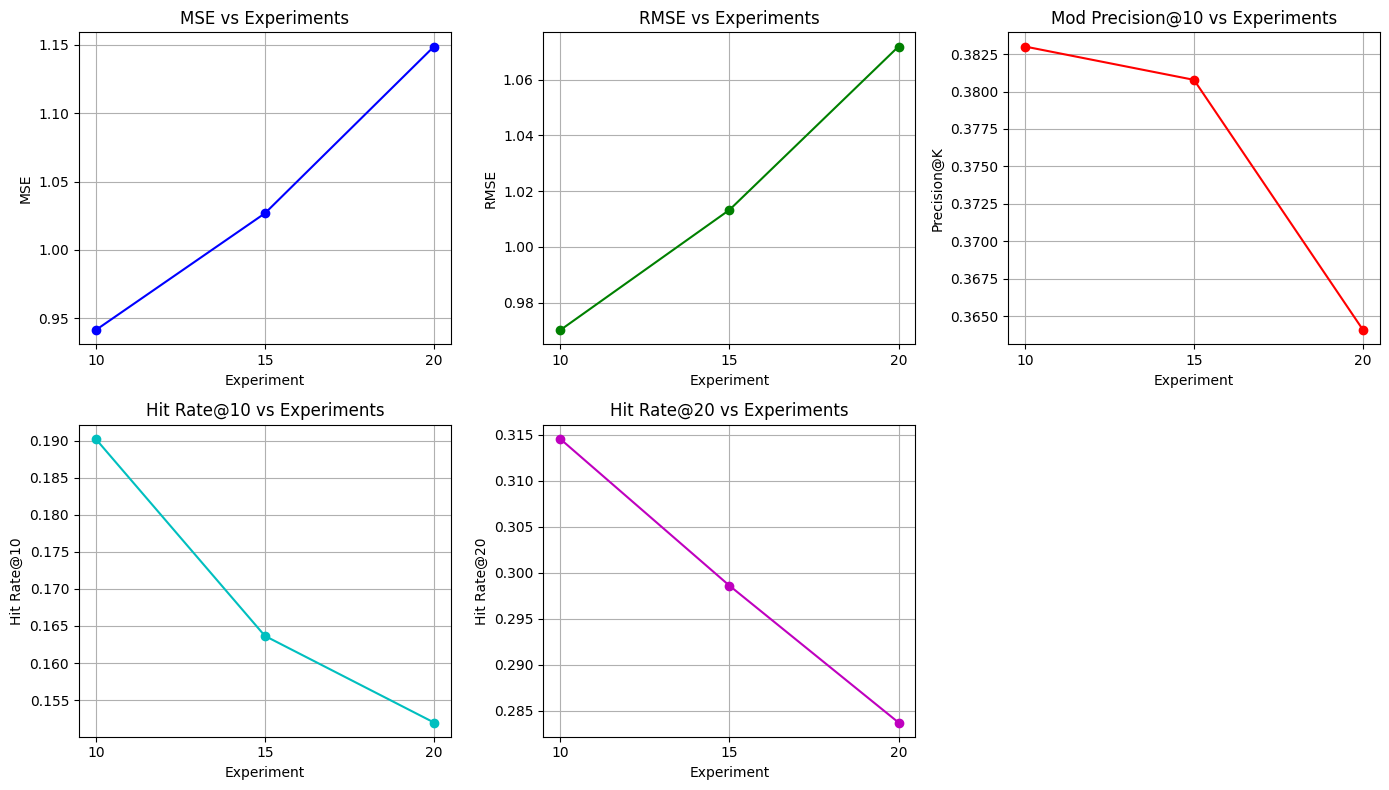

In [272]:
experiments = ["10", "15", "20"]
plot_metrics(experiments, mses_HD, rmses_HD, precisions_k_HD, hit_rates_10_HD, hit_rates_20_HD)

##### Exp 4: 70 embedding dim, 10 epochs

In [273]:
mses_HD = []
rmses_HD = []
precisions_k_HD = []
hit_rates_10_HD = []
hit_rates_20_HD = []

In [274]:
embedding_dim = 70
num_epochs = 10

model = HybridRecSys(num_users, num_items, num_genres, embedding_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

losses_e4 = train_hybrid_recommender(model, train_dataloader, criterion, optimizer, num_epochs)

Epoch 1/10, Loss: 1.1817977588117266
Epoch 2/10, Loss: 0.9368501464302081
Epoch 3/10, Loss: 0.8823144033323443
Epoch 4/10, Loss: 0.8440117174257508
Epoch 5/10, Loss: 0.8145548925702838
Epoch 6/10, Loss: 0.7860828388005807
Epoch 7/10, Loss: 0.7559552591171173
Epoch 8/10, Loss: 0.7250888987068965
Epoch 9/10, Loss: 0.6965015399916366
Epoch 10/10, Loss: 0.6680448859666301


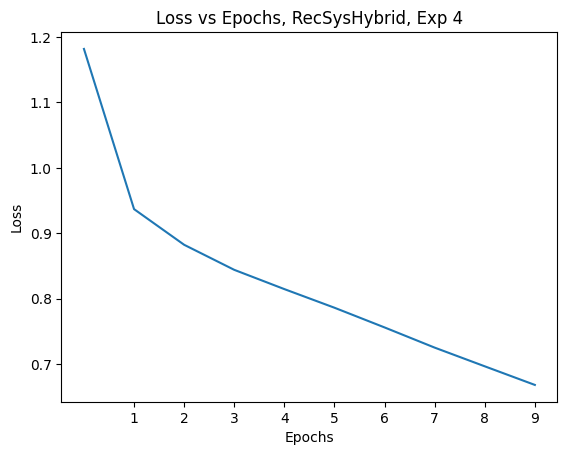

In [275]:
plot_training_epochs(losses_e4, "RecSysHybrid, Exp 4", 10)

In [276]:
mse, rmse = get_mse_rmse_hybrid(model, test_ratings, test_users, test_items, test_genres, test_sentiments)
precision_k = get_precision_at_k_hybrid(test_data, model, user_id_map, item_id_map, item_id_reverse_map, top_n=10)
hit_rate_10 = calculate_hit_rate_hybrid(model, test_data, user_id_map, item_id_map, item_id_reverse_map, test_items_unique, k=10)
hit_rate_20 = calculate_hit_rate_hybrid(model, test_data, user_id_map, item_id_map, item_id_reverse_map, test_items_unique, k=20)
mses_HD.append(mse)
rmses_HD.append(rmse)
precisions_k_HD.append(precision_k)
hit_rates_10_HD.append(hit_rate_10)
hit_rates_20_HD.append(hit_rate_20)

Test MSE: 1.0036333754084767, Test RMSE: 1.001815040518197
Average Precision: 0.3774373259052925
Hit Rate@10: 0.1742826780021254
Hit Rate@20: 0.31562167906482463


##### Exp 5: 30 embedding dim, 10 epochs

In [277]:
embedding_dim = 30
num_epochs = 10

model = HybridRecSys(num_users, num_items, num_genres, embedding_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

losses_e5 = train_hybrid_recommender(model, train_dataloader, criterion, optimizer, num_epochs)

Epoch 1/10, Loss: 1.2799893703944052
Epoch 2/10, Loss: 0.9702515174137999
Epoch 3/10, Loss: 0.9073856727835256
Epoch 4/10, Loss: 0.8748747225212457
Epoch 5/10, Loss: 0.8537903609337196
Epoch 6/10, Loss: 0.8354559104143374
Epoch 7/10, Loss: 0.8235867659794354
Epoch 8/10, Loss: 0.807997998674359
Epoch 9/10, Loss: 0.7903195424177718
Epoch 10/10, Loss: 0.7739901620106455


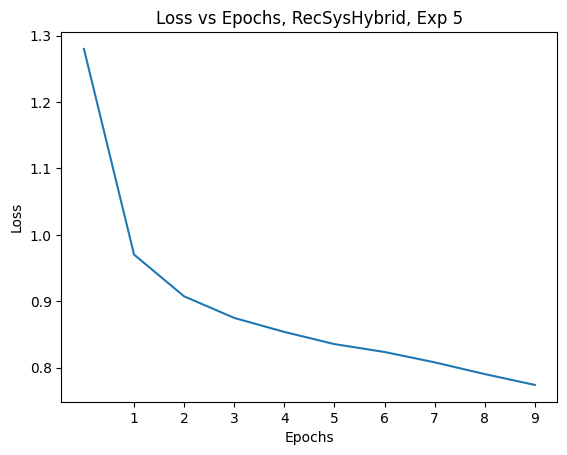

In [278]:
plot_training_epochs(losses_e5, "RecSysHybrid, Exp 5", 10)

In [279]:
mse, rmse = get_mse_rmse_hybrid(model, test_ratings, test_users, test_items, test_genres, test_sentiments)
precision_k = get_precision_at_k_hybrid(test_data, model, user_id_map, item_id_map, item_id_reverse_map, top_n=10)
hit_rate_10 = calculate_hit_rate_hybrid(model, test_data, user_id_map, item_id_map, item_id_reverse_map, test_items_unique, k=10)
hit_rate_20 = calculate_hit_rate_hybrid(model, test_data, user_id_map, item_id_map, item_id_reverse_map, test_items_unique, k=20)
mses_HD.append(mse)
rmses_HD.append(rmse)
precisions_k_HD.append(precision_k)
hit_rates_10_HD.append(hit_rate_10)
hit_rates_20_HD.append(hit_rate_20)

Test MSE: 0.9257823728856561, Test RMSE: 0.962175853410205
Average Precision: 0.3874651810584958
Hit Rate@10: 0.1381509032943677
Hit Rate@20: 0.28055260361317746


##### Exp 6: 20 embedding dim, 10 epochs

In [280]:
embedding_dim = 20
num_epochs = 10

model = HybridRecSys(num_users, num_items, num_genres, embedding_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

losses_e6 = train_hybrid_recommender(model, train_dataloader, criterion, optimizer, num_epochs)

Epoch 1/10, Loss: 1.3336223273246592
Epoch 2/10, Loss: 1.010878989702257
Epoch 3/10, Loss: 0.9337233695308719
Epoch 4/10, Loss: 0.8914947486029262
Epoch 5/10, Loss: 0.8694487221041516
Epoch 6/10, Loss: 0.8500031501126692
Epoch 7/10, Loss: 0.837773576318882
Epoch 8/10, Loss: 0.8283596097080341
Epoch 9/10, Loss: 0.8162735904883878
Epoch 10/10, Loss: 0.8054797621811002


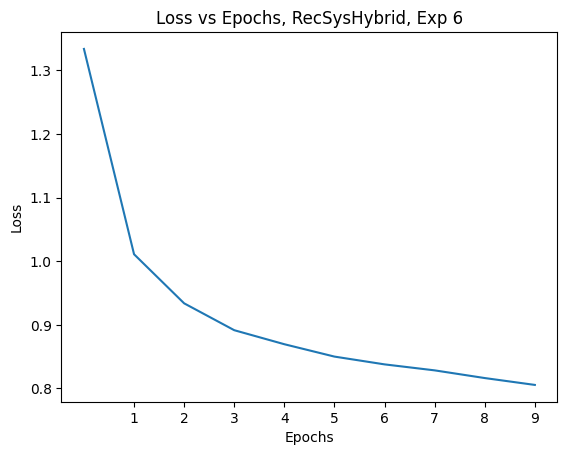

In [281]:
plot_training_epochs(losses_e6, "RecSysHybrid, Exp 6", 10)

In [282]:
mse, rmse = get_mse_rmse_hybrid(model, test_ratings, test_users, test_items, test_genres, test_sentiments)
precision_k = get_precision_at_k_hybrid(test_data, model, user_id_map, item_id_map, item_id_reverse_map, top_n=10)
hit_rate_10 = calculate_hit_rate_hybrid(model, test_data, user_id_map, item_id_map, item_id_reverse_map, test_items_unique, k=10)
hit_rate_20 = calculate_hit_rate_hybrid(model, test_data, user_id_map, item_id_map, item_id_reverse_map, test_items_unique, k=20)
mses_HD.append(mse)
rmses_HD.append(rmse)
precisions_k_HD.append(precision_k)
hit_rates_10_HD.append(hit_rate_10)
hit_rates_20_HD.append(hit_rate_20)

Test MSE: 0.9112597007070204, Test RMSE: 0.9545992356518103
Average Precision: 0.3910863509749304
Hit Rate@10: 0.2051009564293305
Hit Rate@20: 0.34537725823591925


##### Exp 7: 15 embedding dim, 10 epochs

In [283]:
embedding_dim = 15
num_epochs = 10

model = HybridRecSys(num_users, num_items, num_genres, embedding_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

losses_e7 = train_hybrid_recommender(model, train_dataloader, criterion, optimizer, num_epochs)

Epoch 1/10, Loss: 1.307181232414798
Epoch 2/10, Loss: 1.016455869279556
Epoch 3/10, Loss: 0.9370697299415607
Epoch 4/10, Loss: 0.8958487027082727
Epoch 5/10, Loss: 0.8733739264531185
Epoch 6/10, Loss: 0.8569794399356612
Epoch 7/10, Loss: 0.8463637722852435
Epoch 8/10, Loss: 0.836304657586812
Epoch 9/10, Loss: 0.8258847099393966
Epoch 10/10, Loss: 0.8171111335221165


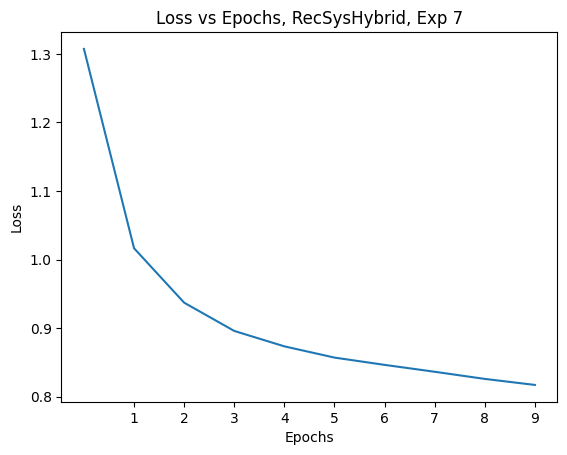

In [284]:
plot_training_epochs(losses_e7, "RecSysHybrid, Exp 7", 10)

In [285]:
mse, rmse = get_mse_rmse_hybrid(model, test_ratings, test_users, test_items, test_genres, test_sentiments)
precision_k = get_precision_at_k_hybrid(test_data, model, user_id_map, item_id_map, item_id_reverse_map, top_n=10)
hit_rate_10 = calculate_hit_rate_hybrid(model, test_data, user_id_map, item_id_map, item_id_reverse_map, test_items_unique, k=10)
hit_rate_20 = calculate_hit_rate_hybrid(model, test_data, user_id_map, item_id_map, item_id_reverse_map, test_items_unique, k=20)
mses_HD.append(mse)
rmses_HD.append(rmse)
precisions_k_HD.append(precision_k)
hit_rates_10_HD.append(hit_rate_10)
hit_rates_20_HD.append(hit_rate_20)

Test MSE: 0.9085571300287714, Test RMSE: 0.9531826320431838
Average Precision: 0.3877437325905292
Hit Rate@10: 0.20722635494155153
Hit Rate@20: 0.3528161530286929


##### Embedding Dim Results

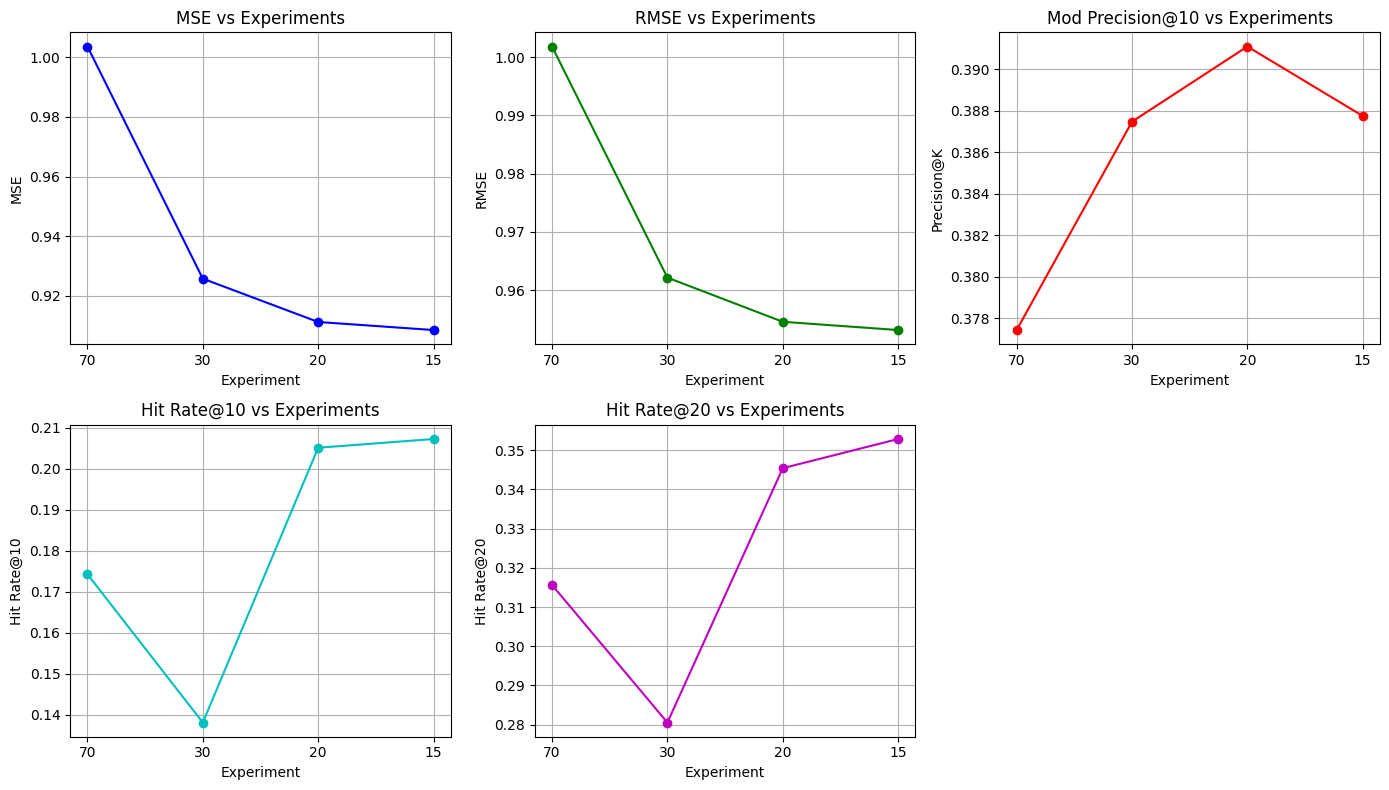

In [286]:
experiments = ["70", "30", "20", "15"]
plot_metrics(experiments, mses_HD, rmses_HD, precisions_k_HD, hit_rates_10_HD, hit_rates_20_HD)

## APPENDIX

Precision @10 industry standards:

Typical Precision Benchmarks by Domain
E-commerce:

Amazon, eBay, etc.: Precision@10 can range from 20% to 40%. High precision is crucial here as it directly impacts sales and user satisfaction.
Streaming Services:

Netflix, Spotify, etc.: Precision@10 often ranges from 25% to 50%. Recommendations significantly affect user engagement and retention.
Social Media:

Facebook, Twitter, etc.: Precision might be lower, ranging from 10% to 30%, due to the vast amount of diverse content and the focus on personalized feeds rather than precise recommendations.
News and Articles:

Google News, Flipboard, etc.: Precision can range from 15% to 35%. The goal is to keep users engaged with relevant articles.


References

[1] J. Bennett and S. Lanning, "The Netflix Prize," in Proceedings of KDD Cup and Workshop, 2007.

[2] G. Linden, B. Smith, and J. York, "Amazon.com Recommendations: Item-to-Item Collaborative Filtering," IEEE Internet Computing, vol. 7, no. 1, pp. 76-80, Jan.-Feb. 2003.

[3] A. Leino, "How Spotify Recommends Your New Favorite Artist," Spotify Engineering Blog, 2017. [Online]. Available: https://engineering.atspotify.com/2017/02/how-spotify-recommends-your-new-favorite-artist/

[4] M. J. Pazzani and D. Billsus, "Content-Based Recommendation Systems," in The Adaptive Web, P. Brusilovsky, A. Kobsa, and W. Nejdl, Eds. Berlin, Heidelberg: Springer-Verlag, 2007, pp. 325-341.